# **Final Project Code**



## **Initiation**

Install PyDrive and import related packages

In [0]:
#Please run this first
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
#import modules

import numpy as np
import pandas as pd
# from statsmodels.formula.api import ols
from statsmodels.formula.api import logit
import matplotlib.pyplot as plt
import sklearn 
import scipy.special as spsp
from scipy.optimize import minimize
import scipy.stats as spst
from sklearn.utils import shuffle

## **Data Loading**

Load three datasets

- Email<br>Include the email sending information of each customer in the email list.

In [0]:
link="https://drive.google.com/open?id=1nUDYawHbpUHhrEX3dVjZk4K5pU5blXDH"
_,id=link.split("=")
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('online_shoppers_intention.csv')
Email = pd.read_csv('email.csv')
Email.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases
0,85120,short_email,personalized,2,Sunday,US,5
1,966622,long_email,personalized,12,Sunday,UK,2
2,777221,long_email,personalized,11,Wednesday,US,2
3,493711,short_email,generic,6,Monday,UK,1
4,106887,long_email,generic,14,Monday,US,6


- Open<br>
Include the `email_id` of the customers who opened the email.

In [0]:
link="https://drive.google.com/open?id=1psb8T4n1KgjrzzrpIyW50BIa88l6IE9U"
_,id=link.split("=")
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('email_opened_table.csv')
Open = pd.read_csv('email_opened_table.csv')
Open.head()

,email_id
0,284534
1,609056
2,220820
3,905936
4,164034


- Link<br>
Include the `email_id` of the customers who clicked the link in the email.

In [0]:
link="https://drive.google.com/open?id=11tiiBfFAmF516hDFr3tyKsbwkMigsJVv"
_,id=link.split("=")
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('link_clicked_table.csv')
Link = pd.read_csv('link_clicked_table.csv')
Link.head()

,email_id
0,609056
1,870980
2,935124
3,158501
4,177561


## **Data Cleaning**

Merge datasets and delete invalid values

In [0]:
# Add dummy values to the Open & Link datasets
Open = Open.assign(Open=1)
Link = Link.assign(Link=1)

In [0]:
# Divided column `hour` into different time slot
data = Email.assign(hour_time = pd.cut(Email['hour'], np.arange(0, 25, 6), labels=['night', 'morning', 'afternoon', 'evening']))

In [0]:
# Merge three datasets and complement the dummy values
data = data.merge(Open, how='left', on='email_id')
data = data.merge(Link, how='left', on='email_id')
data = data.fillna({"Open":0,"Link":0})

In [0]:
# Drop invalid data (didn't open the email but click the link)
filter1 = ~ ((data["Open"] == 0) & (data["Link"] == 1))
data = data[filter1].dropna()
data.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,hour_time,Open,Link
0,85120,short_email,personalized,2,Sunday,US,5,night,0.0,0.0
1,966622,long_email,personalized,12,Sunday,UK,2,morning,1.0,1.0
2,777221,long_email,personalized,11,Wednesday,US,2,morning,0.0,0.0
3,493711,short_email,generic,6,Monday,UK,1,night,0.0,0.0
4,106887,long_email,generic,14,Monday,US,6,afternoon,0.0,0.0


In [0]:
data.dtypes

email_id                  int64
email_text               object
email_version            object
hour                      int64
weekday                  object
user_country             object
user_past_purchases       int64
hour_time              category
Open                    float64
Link                    float64
dtype: object

## **Data Preparation & Exploration**

- Data Spliting<br>Separate dataset for model training and the evaluation of the model accuracy.

In [0]:
# Shuffle data
data_s = shuffle(data)
data_s = pd.concat([data_s,\
                    pd.get_dummies(data_s['email_text']),\
                    pd.get_dummies(data_s['email_version']),\
                    pd.get_dummies(data_s['hour_time']),\
                    pd.get_dummies(data_s['weekday']),\
                    pd.get_dummies(data_s['user_country'])], axis=1)

# Training set: 80%
T_train = data_s[0:int(0.80*data_s.shape[0])]
# Validation set: 10%
T_valid = data_s[int(0.80*data_s.shape[0]):int(0.90*data_s.shape[0])]
# Testing set: 10%
T_test = data_s[int(0.90*data_s.shape[0]):]

- Continuous Variables


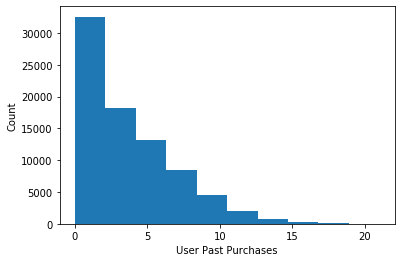

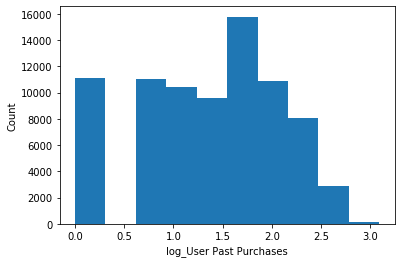

In [0]:
# user_past_purchases Log Transformation
a = plt.figure(1)
plt.hist(T_train['user_past_purchases'])
plt.xlabel('User Past Purchases')
plt.ylabel('Count')
a.show()

b = plt.figure(2)
plt.hist(np.log(T_train['user_past_purchases']+1))
plt.xlabel('log_User Past Purchases')
plt.ylabel('Count')
b.show()

In [0]:
np.mean(data_s["Link"].values)

0.020700350175087544

- Categorical Variables 

In [0]:
T_train.groupby('email_text').mean()[["Open","Link"]]

,Open,Link
email_text,,
long_email,0.090452,0.017931
short_email,0.116867,0.023640


In [0]:
T_train.groupby('email_version').mean()[["Open","Link"]]

,Open,Link
email_version,,
generic,0.079009,0.014420
personalized,0.128323,0.027159


In [0]:
T_train.groupby('hour_time').mean()[["Open","Link"]]

,Open,Link
hour_time,,
night,0.085392,0.017169
morning,0.113971,0.023074
afternoon,0.107466,0.020771
evening,0.080594,0.015907


In [0]:
T_train.groupby('weekday').mean()[["Open","Link"]]

,Open,Link
weekday,,
Friday,0.073969,0.014123
Monday,0.116816,0.023415
Saturday,0.088072,0.017614
Sunday,0.086923,0.014675
Thursday,0.114670,0.024113
Tuesday,0.119286,0.023521
Wednesday,0.123206,0.027280


In [0]:
T_train.groupby('user_country').mean()[["Open","Link"]]

,Open,Link
user_country,,
ES,0.039540,0.007832
FR,0.041028,0.006859
UK,0.118974,0.024071
US,0.118780,0.023922


## **Logistic Model**

### Model Building (Evaluation)



- Open

In [0]:
candidate_variables=np.array([ 'C(email_version)', 'C(hour_time)', 'C(weekday)','C(user_country)'])

full=len(candidate_variables)
best_model="Open~np.log(user_past_purchases+1)"
BEST_BIC=np.inf
actual=T_valid["Open"].values
for i in np.arange(full-1,-1,-1):
  BIC=np.empty(i+1)
  for j in range(i+1):
    candidate_formula=best_model+"+"+candidate_variables[j]
    model = logit(formula=candidate_formula,data=T_train).fit()
    BIC[j]= model.bic
    prediction=model.predict(T_valid)
  print(BIC)
  if BEST_BIC>np.min(BIC):
    Add_i=np.where(BIC==np.min(BIC))[0][0]
    best_model=best_model+"+"+candidate_variables[Add_i]
    #print(Add_i)
    print("variable added:", candidate_variables[Add_i])
   # print(best_model)
    BEST_BIC=np.min(BIC)
    candidate_variables=np.delete(candidate_variables,Add_i)    
  else:
    break
    
best_model

Optimization terminated successfully.
         Current function value: 0.323997
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.326429
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.325495
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.320754
         Iterations 7
[51847.47204823 52258.93949054 52143.4380086  51351.47132678]
variable added: C(user_country)
Optimization terminated successfully.
         Current function value: 0.317348
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.319818
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.318844
         Iterations 7
[50817.97158854 51235.61690443 51113.77885513]
variable added: C(email_version)
Optimization terminated successfully.
         Current function value: 0.316410
         Iterations 7
Optimizati

'Open~np.log(user_past_purchases+1)+C(user_country)+C(email_version)+C(weekday)+C(hour_time)'

- Link


In [0]:
candidate_variables=np.array(['C(email_text)', 'C(email_version)', 'C(hour_time)', \
                              'C(weekday)','C(user_country)'])
full=len(candidate_variables)
best_model="Link~np.log(user_past_purchases+1)"
BEST_BIC=np.inf
actual=T_valid["Open"].values
for i in np.arange(full-1,-1,-1):
  BIC=np.empty(i+1)
  for j in range(i+1):
    candidate_formula=best_model+"+"+candidate_variables[j]
    model = logit(formula=candidate_formula,data=T_train).fit()
    BIC[j]= model.bic
    prediction=model.predict(T_valid)
  print(BIC)
  if BEST_BIC>np.min(BIC):
    Add_i=np.where(BIC==np.min(BIC))[0][0]
    best_model=best_model+"+"+candidate_variables[Add_i]
    #print(Add_i)
    print("variable added:", candidate_variables[Add_i])
   # print(best_model)
    BEST_BIC=np.min(BIC)
    candidate_variables=np.delete(candidate_variables,Add_i)    
  else:
    break
    
best_model

Optimization terminated successfully.
         Current function value: 0.094877
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.094115
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.094968
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.094558
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.093704
         Iterations 9
[15206.52804541 15084.68332366 15243.67123709 15211.9544521
 15041.51838783]
variable added: C(user_country)
Optimization terminated successfully.
         Current function value: 0.093433
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.092674
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.093528
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.09

'Link~np.log(user_past_purchases+1)+C(user_country)+C(email_version)+C(email_text)+C(weekday)'

### Model Summary

In [0]:
# logistic model
best_model = 'Link~np.log(user_past_purchases+1)+C(user_country)+C(email_version)+C(weekday)+C(email_text)'
model_logit = logit(formula=best_model,data=T_train).fit()

Optimization terminated successfully.
         Current function value: 0.091815
         Iterations 9


In [0]:
print(model_logit.summary())

                           Logit Regression Results                           
Dep. Variable:                   Link   No. Observations:                79960
Model:                          Logit   Df Residuals:                    79947
Method:                           MLE   Df Model:                           12
Date:                Sun, 15 Dec 2019   Pseudo R-squ.:                 0.08687
Time:                        16:36:15   Log-Likelihood:                -7341.5
converged:                       True   LL-Null:                       -8040.0
Covariance Type:            nonrobust   LLR p-value:                6.360e-292
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -7.7231      0.176    -43.805      0.000      -8.069      -7.378
C(user_country)[T.FR]               -0.1338      0.187     -0.718

In [0]:
# logistic model prediction and precision
prediction = model_logit.predict(T_valid)
T_valid = T_valid.assign(Predicted_P=prediction)
T_valid['Predicted_Click_Rate'] = np.where(T_valid['Predicted_P']>0.5,1,0)
T_valid['Precision'] = np.where(T_valid['Predicted_Click_Rate']==T_valid['Link'],1,0)

In [0]:
np.mean(T_valid['Precision'].values)
T_valid.groupby(['Open','Link']).mean()[["Predicted_P"]]
np.mean(T_valid['Predicted_P'].values)
np.mean(T_valid['Link'].values)

0.019409704852426213

In [0]:
# Average predcited click rate for those who actually clicked the link
print(np.mean(prediction[T_valid["Link"]==1]))
# Average predicted click rate for those who did not click the link
print(np.mean(prediction[T_valid["Link"]==0]))

0.03939836395482724
0.0199200489042222


In [0]:
# AIC and BIC on test data
# Open: Test Set AIC and BIC
model1 = logit("Open~np.log(user_past_purchases+1)+C(user_country)+C(email_version)+C(weekday)+C(hour_time)",data=T_test).fit()
print("AIC: ",model1.aic)
print("BIC: ", model1.bic)

Optimization terminated successfully.
         Current function value: 0.323400
         Iterations 7
AIC:  6494.759002345519
BIC:  6602.906606049536


In [0]:
# Test Set AIC and BIC
model1 = logit("Link~np.log(user_past_purchases+1)+C(user_country)+C(email_version)+C(weekday)+C(email_text)",data=T_test).fit()
print("AIC: ",model1.aic)
print("BIC: ", model1.bic)

Optimization terminated successfully.
         Current function value: 0.098585
         Iterations 9
AIC:  1996.7077690485944
BIC:  2090.435692258743


## **Decision Tree**

In [0]:
from sklearn.tree import DecisionTreeRegressor
# from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree.export import export_text
from sklearn import tree
import graphviz
from sklearn.ensemble import RandomForestRegressor

In [0]:
T_train.columns

Index(['email_id', 'email_text', 'email_version', 'hour', 'weekday',
       'user_country', 'user_past_purchases', 'hour_time', 'Open', 'Link',
       'long_email', 'short_email', 'generic', 'personalized', 'night',
       'morning', 'afternoon', 'evening', 'Friday', 'Monday', 'Saturday',
       'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'ES', 'FR', 'UK', 'US'],
      dtype='object')

- Open

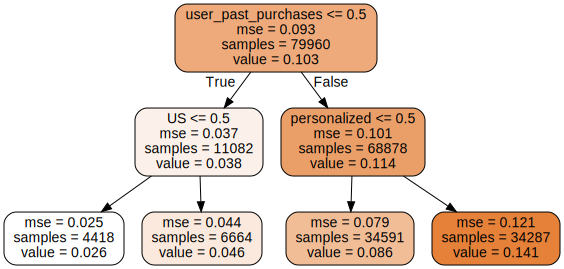

In [0]:
Features_op=['personalized', 'user_past_purchases', \
             'morning', 'afternoon', 'evening', 'night', \
             'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', \
             'UK', 'US', 'ES', 'FR']

model_dt_open = DecisionTreeRegressor(max_depth=2)

model_dt_open_fit = model_dt_open.fit(T_train[Features_op], T_train['Open'])

# path = export_text(model_dt_open_fit, feature_names=Features_op)

dot_data_op = tree.export_graphviz(model_dt_open_fit, out_file=None, 
                                feature_names=Features_op,  
                                class_names='Open',  
                                filled=True, rounded=True)  
graph_op = graphviz.Source(dot_data_op) 
graph_op

In [0]:
def MSE_op(features):
  model_rf_open=RandomForestRegressor(max_depth=2,n_estimators=100,bootstrap=False,max_features=features)
  model_rf_open.fit(T_train[Features_op], T_train['Open'])
  prediction=np.exp(model_rf_open.predict(T_valid[Features_op]))
  MSE=(np.mean((prediction-T_valid['Open'].values)**2))**0.5
  return MSE

i_array=np.arange(len(Features_op))
MSE_array=np.array([MSE_op(i+1) for i in i_array])
print('best features:', i_array[np.argmin(MSE_array)]+1, '\nbest MSE:', np.min(MSE_array))

best features: 9 
best MSE: 1.0505390663815424


- Link

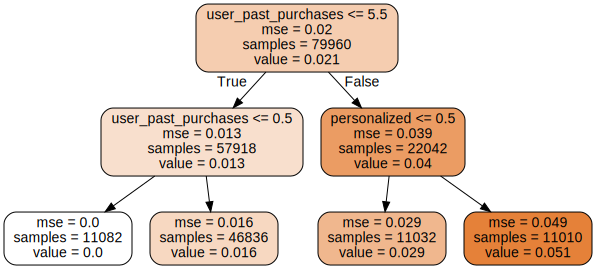

In [0]:
Features_lk=['long_email', 'personalized', 'user_past_purchases', \
             'morning', 'afternoon', 'evening', 'night', \
             'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', \
             'UK', 'US', 'ES', 'FR']

model_dt_link = DecisionTreeRegressor(max_depth=2)

model_dt_link_fit = model_dt_link.fit(T_train[Features_lk], T_train['Link'])

# path = export_text(model_dt_link_fit, feature_names=Features_lk)

dot_data_lk = tree.export_graphviz(model_dt_link_fit, out_file=None, 
                                feature_names=Features_lk,  
                                class_names='Link',  
                                filled=True, rounded=True)  
graph_lk = graphviz.Source(dot_data_lk) 
graph_lk

In [0]:
def MSE_lk(features):
  model_rf_link=RandomForestRegressor(max_depth=2,n_estimators=100,bootstrap=False,max_features=features)
  model_rf_link.fit(T_train[Features_lk], T_train['Link'])
  prediction = np.exp(model_rf_link.predict(T_valid[Features_lk]))
  MSE = (np.mean((prediction-T_valid['Link'].values)**2))**0.5
  return MSE

i_array=np.arange(len(Features_lk))
MSE_array=np.array([MSE_lk(i+1) for i in i_array])
print('best features:', i_array[np.argmin(MSE_array)]+1, '\nbest MSE:', np.min(MSE_array))

best features: 18 
best MSE: 1.010629988928023


## **KNN**


### US



In [0]:
#filter1 = (data["Open"] == 1) & (data["Link"]==1)
#index1 = data[filter1]
data_feature=pd.concat([data,pd.get_dummies(data["email_text"]),pd.get_dummies(data["email_version"]),
                  pd.get_dummies(data["hour_time"]),pd.get_dummies(data["weekday"]),pd.get_dummies(data["user_country"])],
                  axis=1)
data_feature = data_feature.drop(columns=['email_text', 'email_version', 'hour_time', 'weekday','user_country','hour'])
data_feature.columns

Index(['email_id', 'user_past_purchases', 'Open', 'Link', 'long_email',
       'short_email', 'generic', 'personalized', 'night', 'morning',
       'afternoon', 'evening', 'Friday', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday', 'ES', 'FR', 'UK', 'US'],
      dtype='object')

In [0]:
Features=['user_past_purchases','long_email','short_email', 'generic', 
          'personalized', 'night', 'morning', 'afternoon', 'evening',   
          'Friday','Monday', 'Saturday', 'Sunday', 'Thursday',
          'Tuesday',  'Wednesday']

In [0]:
# US/UK section 
filter2 = data_feature['US'] == 1
filter3 = data_feature['UK'] == 1
data_feature_us = data_feature[filter2].drop(columns=['ES', 'FR','UK','US'])
data_feature_us = data_feature_us.reset_index(drop=True)
data_feature_uk = data_feature[filter3].drop(columns=['ES', 'FR','UK','US'])
data_feature_uk = data_feature_uk.reset_index(drop=True)

filter1 = (data_feature_us["Open"] == 1) & (data_feature_us["Link"]==1)
filter2 = (data_feature_uk["Open"] == 1) & (data_feature_uk["Link"]==1)
index1_us = data_feature_us[filter1]
index1_uk = data_feature_uk[filter2]

print("US Total:",data_feature_us.shape[0])
print("UK Total:",data_feature_uk.shape[0])
print("US click and open:",index1_us.shape[0])
print("UK click and open:",index1_uk.shape[0])

US Total: 60069
UK Total: 19928
US click and open: 1434
UK click and open: 481


In [0]:
from sklearn.preprocessing import StandardScaler
model=StandardScaler()
model.fit(data_feature_us[Features])
data_feature_us_s=model.transform(data_feature_us[Features])

from sklearn.neighbors import NearestNeighbors
model=NearestNeighbors(n_neighbors=5,radius=np.inf)
model.fit(data_feature_us_s)

distances,indices=model.radius_neighbors(data_feature_us_s[index1_us.index,:],radius = np.inf)
distance=np.sum(distances)
indices_reordered=np.argsort(distance)


In [0]:
# Customers to pay attention to for US section
target_us = data_feature_us.iloc[indices_reordered[0:6000],:]


### UK

In [0]:
from sklearn.preprocessing import StandardScaler
model=StandardScaler()
model.fit(data_feature_uk[Features])
data_feature_uk_s=model.transform(data_feature_uk[Features])

from sklearn.neighbors import NearestNeighbors
model=NearestNeighbors(n_neighbors=5,radius=np.inf)
model.fit(data_feature_uk_s)

distances,indices=model.radius_neighbors(data_feature_uk_s[index1_uk.index,:],radius = np.inf)
distance=np.sum(distances)
indices_reordered=np.argsort(distance)

In [0]:
# Customers to pay attention to for US section
data_feature_uk.iloc[indices_reordered[0:2000],0:1]

,email_id
13557,77982
13586,641071
13575,228087
13561,888275
17981,809513
...,...
12627,625848
18778,757866
15279,834283
12694,655963


## **A/B Testing** 

### A/B testing: Email Text Length 

In [0]:
print('Number of clicks - Control:',np.sum(data_s[data_s["email_text"]=="long_email"]['Link']))
print('Number of clicks - Experiment:',np.sum(data_s[data_s["email_text"]=="short_email"]['Link']))
# Open rate and click rate
data_s.groupby('email_text').mean()[["Open","Link"]]

Number of clicks - Control: 904.0
Number of clicks - Experiment: 1165.0


,Open,Link
email_text,,
long_email,0.091228,0.017991
short_email,0.115911,0.023440


### Perform an A/B testing based on logitistic regression. 

A summary of click rate by different email text versions:

|Variant|Email Text Version|Users|Number of Clicks|Avergage Click Rate|
|---|---|---|---|---|
|Control|Long|50248|904|0.017991|
|Experiment|Short|49702|1165|0.023440|



In [0]:
from statsmodels.formula.api import logit
print(logit("Link~email_text",data=T_train).fit().summary())
print('Increase in click rate:',	0.023440-0.017991)
print('Percentage increase in click rate:',(0.023440-0.017991)/0.017991)

Optimization terminated successfully.
         Current function value: 0.100290
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                   Link   No. Observations:                79960
Model:                          Logit   Df Residuals:                    79958
Method:                           MLE   Df Model:                            1
Date:                Sun, 15 Dec 2019   Pseudo R-squ.:                0.002582
Time:                        16:37:27   Log-Likelihood:                -8019.2
converged:                       True   LL-Null:                       -8040.0
Covariance Type:            nonrobust   LLR p-value:                 1.167e-10
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -4.0321      0.038   -105.745      0.000      -4.

Statistical power and significance for A/B testing:

- Because the p-value is less than 0.05 and also the coefficient is positive, the short email is effective in increasing the click rate.

|Variant|Click Rate|
|---|---|
|Absolute Increase|0.544%|
|Percentage Increase|30.28%|

In [0]:
#regret - best version=short email
Total = data_s.shape[0]
regret_AB = Total*0.023440-np.sum(data_s["Link"])
print(regret_AB,regret_AB/Total)

273.828 0.002739649824912456


- Regret comparing to best version is approximately 273 number of clicks, meaning we have 0.27% less in reward due to executing the learning algorithm instead of behaving optimally, short version, from the very beginning. 

###Multi-Armed Bandits

Implement the multi-armed bandit algorithm using 100 waves.

Wave 1: 1000 people,  𝑃𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑃𝑒𝑥𝑝𝑒𝑟𝑖𝑚𝑒𝑛𝑡=0.5 

Wave 2-100: 1000 people in each wave. If previous waves suggest that the experiment group is better, use  𝑃𝑒𝑥𝑝𝑒𝑟𝑖𝑚𝑒𝑛𝑡=0.7 . Otherwise, use  𝑃𝑒𝑥𝑝𝑒𝑟𝑖𝑚𝑒𝑛𝑡=0.3 .


In [0]:
seg1 = data_s[data_s["email_text"]=="short_email"] #experiment
seg2 = data_s[data_s["email_text"]=="long_email"] #control

Total=data_s.shape[0]
def multiarmed():
  N=1000
  p1=0.5
  N1=np.random.binomial(N,p1)
  N2=N-N1
  samples1=seg1.sample(N1)
  samples2=seg2.sample(N2)
  outcome1=samples1["Link"].values
  outcome2=samples2["Link"].values
  #next waves 
  for i in range(99):
    N=1000
    if np.mean(outcome1)>np.mean(outcome2):
      p1=0.7
    elif np.mean(outcome1)<np.mean(outcome2):
      p1=0.3
    else:
      p1=0.5
    N1=np.random.binomial(N,p1)
    N2=N-N1
    samples1=seg1.sample(N1 )
    samples2=seg2.sample(N2)
    outcome1=np.append(outcome1,samples1["Link"].values)
    outcome2=np.append(outcome2,samples2["Link"].values)
  
  #compute the return values
  if np.mean(outcome1)>np.mean(outcome2):
    regret=np.mean(outcome1)*Total-np.sum(outcome1)-np.sum(outcome2)
  else:
    regret=np.mean(outcome2)*Total-np.sum(outcome1)-np.sum(outcome2)

  return regret, np.mean(outcome1),np.mean(outcome2)

Returns=[multiarmed() for i in range(50)]
Returns=np.array(Returns)
regret_MAB, Avg_CR1, Avg_CR2 = np.mean(Returns[:,0]),np.mean(Returns[:,1]),np.mean(Returns[:,2])
print(regret_MAB, Avg_CR1, Avg_CR2)

162.95828258851398 0.023325245448609446 0.01800518363814644


In [0]:
print(regret_MAB/Total)

0.0016303980248975887


- Regret by MAB simulation is approximately 163 number of clicks, meaning we have 0.163% less in reward due to executing the learning algorithm instead of behaving optimally, short version, from the very beginning. However this simulation result shows a better reward than A/B testing.

### A/B testing: Email Version

In [0]:
#group by email version
# Control variant sample size = 50178 users
print('Number of clicks - Control:',np.sum(data_s[data_s["email_version"]=="generic"]['Link']))
# Experiment variant sample size = 49772 users
print('Number of clicks - Experiment:',np.sum(data_s[data_s["email_version"]=="personalized"]['Link']))

data_s.groupby('email_version').mean()[["Open","Link"]]

Number of clicks - Control: 729.0
Number of clicks - Experiment: 1340.0


,Open,Link
email_version,,
generic,0.079397,0.014528
personalized,0.127803,0.026923


### Perform an A/B testing based on logitistic regression. 

A summary of click rate by different email versions:

|Variant|Email Text Version|Users|Number of Clicks|Avergage Click Rate|
|---|---|---|---|---|
|Control|Generic|50178|729|0.014528|
|Experiment|Personalized|49772|1340|0.026923|

In [0]:
from statsmodels.formula.api import logit
print(logit("Link~email_version",data=T_train).fit().summary())
print('Increase in click rate:',0.026923-0.014528)
print('Percentage increase in click rate:',(0.026923-0.014528)/0.014528)

Optimization terminated successfully.
         Current function value: 0.099533
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                   Link   No. Observations:                79960
Model:                          Logit   Df Residuals:                    79958
Method:                           MLE   Df Model:                            1
Date:                Sun, 15 Dec 2019   Pseudo R-squ.:                 0.01011
Time:                        16:38:13   Log-Likelihood:                -7958.6
converged:                       True   LL-Null:                       -8040.0
Covariance Type:            nonrobust   LLR p-value:                 3.003e-37
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -4.2322      0.042   -100.755      0.

A/B testing:

- Because the p-value is less than 0.05 and also the coefficient is positive, the personalized version is effective in increasing the click rate.

|Variant|Click Rate|
|---|---|
|Absolute Increase|1.240%|
|Percentage Increase|85.32%|

In [0]:
#regret - best version= personalized email
Total = data_s.shape[0]
regret_AB = Total*0.026923-np.sum(data_s["Link"])
print(regret_AB,regret_AB/Total)

621.9538499999999 0.0062226498249124546


- Regret comparing to best version is approximately 622 number of clicks, meaning we have 0.622% less in reward due to executing the learning algorithm instead of behaving optimally, personalized version, from the very beginning. 

###Multi-Armed Bandits

Implement the multi-armed bandit algorithm using 100 waves.

Wave 1: 1000 people,  𝑃𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑃𝑒𝑥𝑝𝑒𝑟𝑖𝑚𝑒𝑛𝑡=0.5 

Wave 2-100: 1000 people in each wave. If previous waves suggest that the experiment group is better, use  𝑃𝑒𝑥𝑝𝑒𝑟𝑖𝑚𝑒𝑛𝑡=0.7 . Otherwise, use  𝑃𝑒𝑥𝑝𝑒𝑟𝑖𝑚𝑒𝑛𝑡=0.3 .

In [0]:
seg1 = data_s[data_s["email_version"]=="personalized"] #experiment
seg2 = data_s[data_s["email_version"]=="generic"] #control

Total=data_s.shape[0]
def multiarmed():
  N=1000
  p1=0.5
  N1=np.random.binomial(N,p1)
  N2=N-N1
  samples1=seg1.sample(N1)
  samples2=seg2.sample(N2)
  outcome1=samples1["Link"].values
  outcome2=samples2["Link"].values
  #next waves 
  for i in range(99):
    N=1000
    if np.mean(outcome1)>np.mean(outcome2):
      p1=0.7
    elif np.mean(outcome1)<np.mean(outcome2):
      p1=0.3
    else:
      p1=0.5
    N1=np.random.binomial(N,p1)
    N2=N-N1
    samples1=seg1.sample(N1 )
    samples2=seg2.sample(N2)
    outcome1=np.append(outcome1,samples1["Link"].values)
    outcome2=np.append(outcome2,samples2["Link"].values)
  
  #compute the return values
  if np.mean(outcome1)>np.mean(outcome2):
    regret=np.mean(outcome1)*Total-np.sum(outcome1)-np.sum(outcome2)
  else:
    regret=np.mean(outcome2)*Total-np.sum(outcome1)-np.sum(outcome2)

  return regret, np.mean(outcome1),np.mean(outcome2)

Returns=[multiarmed() for i in range(50)]
Returns=np.array(Returns)
regret_MAB, Avg_CR1, Avg_CR2 = np.mean(Returns[:,0]),np.mean(Returns[:,1]),np.mean(Returns[:,2])
print(regret_MAB, Avg_CR1, Avg_CR2)

361.155520923258 0.026731520969717436 0.014759053338794726


- Regret by MAB simulation is approximately 361 number of clicks, meaning we have 0.361% less in reward due to executing the learning algorithm instead of behaving optimally,personalized version, from the very beginning. However this simulation result shows a better reward than A/B testing.